In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import keras
import random
from sklearn.model_selection import train_test_split
from keras import ops
from keras import layers
from keras import models

In [2]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# x_train, x_test = x_train_val / 255.0, x_test / 255.0
print("Training data shape:   ", x_train_val.shape)
print("Training labels shape: ", y_train_val.shape)
print("Test data shape:       ", x_test.shape)
print("Test labels shape:     ", y_test.shape)

Training data shape:    (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:        (10000, 28, 28)
Test labels shape:      (10000,)


In [4]:
labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

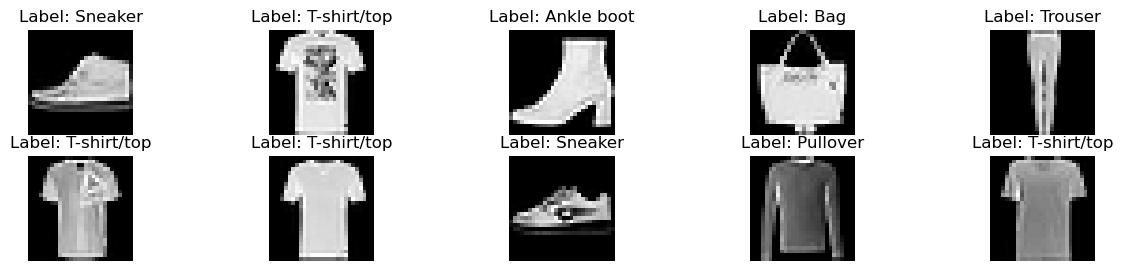

In [5]:
random_indices = np.random.randint(0, len(x_train_val), size=10)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_val[idx], cmap='gray')
    label_num = y_train_val[idx]
    plt.title(f"Label: {labels[label_num]}")
    plt.axis('off')
plt.show()

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

# Normalize the data
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Print shapes
print("Training data shape:   ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Validation data shape: ", x_val.shape)
print("Validation labels shape: ", y_val.shape)
print("Test data shape:       ", x_test.shape)
print("Test labels shape:     ", y_test.shape)

Training data shape:    (48000, 28, 28)
Training labels shape:  (48000,)
Validation data shape:  (12000, 28, 28)
Validation labels shape:  (12000,)
Test data shape:        (10000, 28, 28)
Test labels shape:      (10000,)


In [8]:
def create_pairs(images, labels):
    pair_images, pair_labels = [], []
    n = min([len(labels[l]) for l in range(10)]) - 1
    
    for l in range(10):
        for i in range(n):
            # create positive pair image
            z1, z2 = labels[l][i], labels[l][i + 1]
            pair_images += [[images[z1], images[z2]]]
            
            inc = random.randrange(1, 10)
            dn = (l + inc) % 10
            
            # create negative pair image
            z1, z2 = labels[l][i], labels[dn][i]
            pair_images += [[images[z1], images[z2]]]
            pair_labels += [1,0]
    return np.array(pair_images), np.array(pair_labels)

def create_pairs_on_set(images, labels):
    digit = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit)
    y = y.astype('float32')
    return pairs, y

In [9]:
train_image_pairs, train_label_pairs = create_pairs_on_set(x_train, y_train)
val_image_pairs, val_label_pairs = create_pairs_on_set(x_val, y_val)
test_image_pairs, test_label_pairs = create_pairs_on_set(x_test, y_test)

In [10]:
def show_image(anchor_image, image):
    _, axs = plt.subplots(1,2)
    axs[0].imshow(anchor_image)
    axs[0].grid(False)
    axs[1].imshow(image)
    axs[1].grid(False)
    plt.show()

In [11]:
class BaseNetwork(keras.models.Model):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.flatten = layers.Flatten(name='flatten')
        self.d1 = layers.Dropout(.2, name='dropout_1')
        self.fc1 = layers.Dense(256, activation='relu', name='fully_1')
        self.d2 = layers.Dropout(.2, name='dropout_2')
        self.fc2 = layers.Dense(128, activation='relu', name='fully_2')
    
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.d1(x)
        x = self.fc1(x)
        x = self.d2(x)
        return self.fc2(x)

base_network = BaseNetwork()

In [12]:
input_shape = x_train[0].shape
inputs = layers.Input(shape=input_shape)

# create base model and display model layer
output = base_network(inputs)
base_model = keras.models.Model(inputs, output)

In [13]:
from tensorflow.keras import backend as K

def euclidean(vect):
    x, y = vect
    sum_square = K.sum(K.square(x - y), axis=-1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euclidean_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [14]:
# define the input and output layer for left network
left_input = layers.Input(shape=input_shape, name='left_input')
left_output = base_network(left_input)

# define the input and output layer for right network
right_input = layers.Input(shape=input_shape, name='right_input')
right_output = base_network(right_input)

# measure similarity between vector
output = layers.Lambda(euclidean, name='output_layer', output_shape=euclidean_output_shape)([left_output, right_output])
model = keras.models.Model([left_input, right_input], output)

In [15]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        squared_pred = K.square(y_pred)
        squared_margin = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * squared_pred + (1 - y_true) * squared_margin)
    return contrastive_loss

In [16]:
optimizer = keras.optimizers.RMSprop()
loss = contrastive_loss_with_margin(margin=1)

In [17]:
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_network        │ (None, 128)       │    233,856 │ left_input[0][0], │
│ (BaseNetwork)       │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │          0 │ base_network[1][… │
│ (Lambda)            │                   │            │ base_network[2][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 233,856 (913.50 KB)

 Trainable params: 233,856 (913.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    [train_image_pairs[:, 0], train_image_pairs[:, 1]],
    train_label_pairs,
    epochs=50,
    batch_size=256,
    validation_data=([val_image_pairs[:, 0], val_image_pairs[:, 1]], val_label_pairs)
)

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3764 - val_loss: 0.1096
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1171 - val_loss: 0.1002
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1030 - val_loss: 0.0882
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0960 - val_loss: 0.0881
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0915 - val_loss: 0.0844
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0896 - val_loss: 0.0813
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0866 - val_loss: 0.0814
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0865 - val_loss: 0.0794
Epoch 9/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0849 - val_loss: 0.0818
Epoch 10/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0834 - val_loss: 0.0784
Epoch 11/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0829 - val_loss: 0.0782
Epoch 12/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/s

In [19]:
def compute_accuracy(y_true, y_pred):
    yhat = y_pred.ravel() < .5
    return np.mean(yhat == y_true)

In [20]:
# compute validation accuracy
y_pred_val = model.predict([val_image_pairs[:,0], val_image_pairs[:,1]])
val_accuracy = compute_accuracy(val_label_pairs, y_pred_val)

# compute test accuracy
y_pred_test = model.predict([test_image_pairs[:,0], test_image_pairs[:,1]])
test_accuracy = compute_accuracy(test_label_pairs, y_pred_test)

print("val_accuracy: {:.2f}% - test_accuracy: {:.2f}%".format(val_accuracy*100, test_accuracy*100))

724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
val_accuracy: 90.28% - test_accuracy: 90.27%


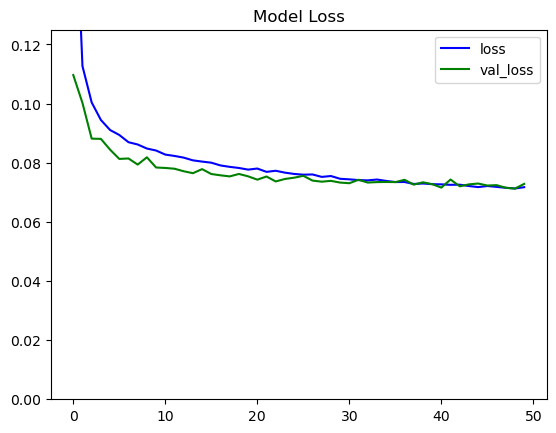

In [21]:
def plot_training_step(metric, title, ylim=1):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric], color='blue', label=metric)
    plt.plot(history.history['val_' + metric], color='green', label='val_' + metric)
    plt.legend([metric, 'val_' + metric], loc='upper right')
    plt.show()

plot_training_step('loss', 'Model Loss', .125)

In [22]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28 * n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5:
            t.set_color('red')
        else:
            t.set_color('green')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28 * n])
    plt.imshow(right)

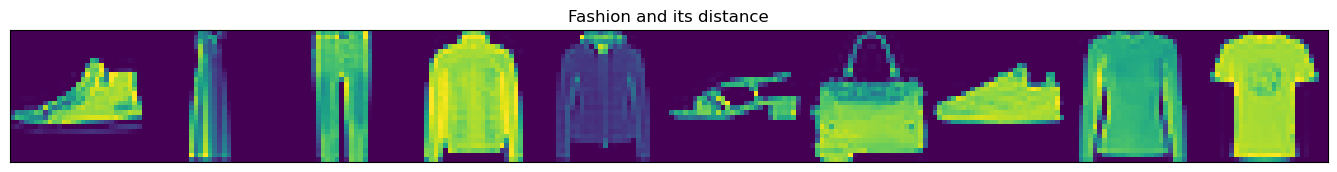

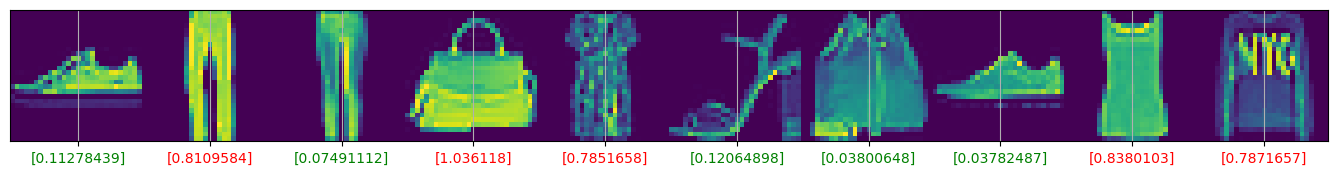

In [23]:
y_pred = np.squeeze(y_pred_test)
idx = np.random.choice(len(y_pred_test), size=10)
display_images(
    test_image_pairs[:, 0][idx],
    test_image_pairs[:, 1][idx],
    y_pred_test[idx],
    test_label_pairs[idx],
    "Fashion and its distance",
    10
)

In [24]:
def cosine_similarity(embeddings1, embeddings2):
    dot_product = np.sum(embeddings1 * embeddings2, axis=-1)
    norms1 = np.linalg.norm(embeddings1, axis=-1)
    norms2 = np.linalg.norm(embeddings2, axis=-1)
    cosine_sim = dot_product / (norms1 * norms2 + 1e-8)  # Adding a small value to avoid division by zero
    return cosine_sim

In [25]:
cosine_similarities = cosine_similarity(test_image_pairs[:, 0][idx], test_image_pairs[:, 1][idx])
cosine_similarities

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.6788861 , 0.42073086,
        0.41017457, 0.64144714, 0.88019979, 0.9179969 , 0.91941661,
        0.92465584, 0.91863116, 0.88388075, 0.09298576, 0.7332767 ,
        0.58541312, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.73388851, 0.78910412, 0.69324303, 0.64137014, 0.63503602,
        0.60221152, 0.59450355, 0.6260607 , 0.66199127, 0.64738423,
        0.62365052, 0.59691084, 0.54225732, 0.53511055, 0.54440506,
        0.57736262, 0.59033967, 0.64806161, 0.71041244, 0.73170441,
        0.72729905, 0.7243892 , 0.72332901, 0.69857934, 0.68264499,
        0.71057154, 0.76467501, 0.63724229],
       [0.85757805, 0.86901446, 0.94146346, 0.95312622, 0.94353467,
        0.94935719, 0.93826238, 0.92682126, 0.89555091, 0.87714037,
        0.8927169 , 0.86834743, 0.86574868, 0.86728399, 0.85348752,
        0.8397537 , 0.8465